# Shapley Values

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
plt.style.use("style.mplstyle")

## Load and Prepare Data

In [59]:
features = ["% working class", "number of rooms", "Air pollution"]
df = pd.read_csv("data.csv")
df.rename(columns={"y": "Price"}, inplace=True)
df.rename(columns={"NOX concentration": "Air pollution"}, inplace=True)
y = df["Price"].values

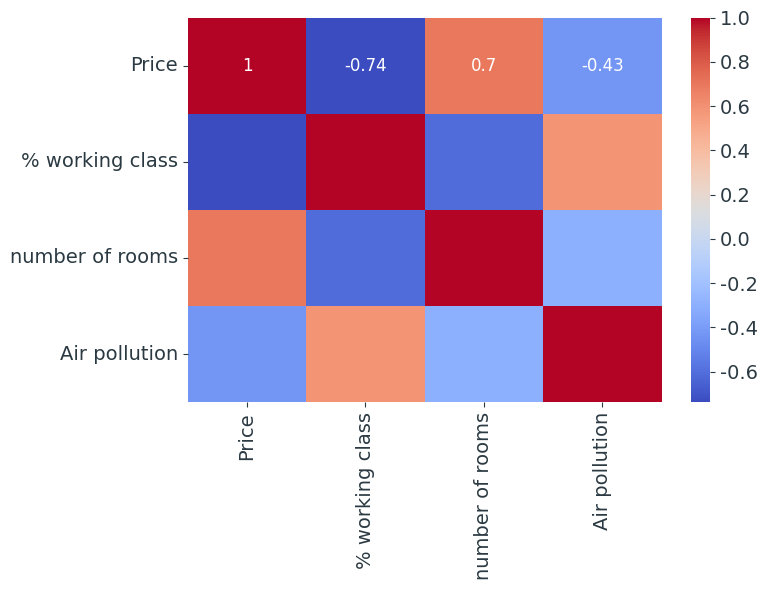

In [90]:
# Plot correlation matrix

plt.figure(figsize=(8, 6))
df_sub = df[["Price"]+features]
sns.heatmap(df_sub.corr(), annot=True, cmap="coolwarm", annot_kws={"fontsize":12})
plt.tight_layout()

## Linear regression

In [74]:
df_sub_sub = df[features]

X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
# Train linear regression model

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model coefficients:")
for feature, coef in zip(features, model.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

Model coefficients:
% working class: -305.06
number of rooms: 5184.91
Air pollution: -4286.24
Intercept: 72.64


In [77]:
print(np.mean(y))

22532.806324110672


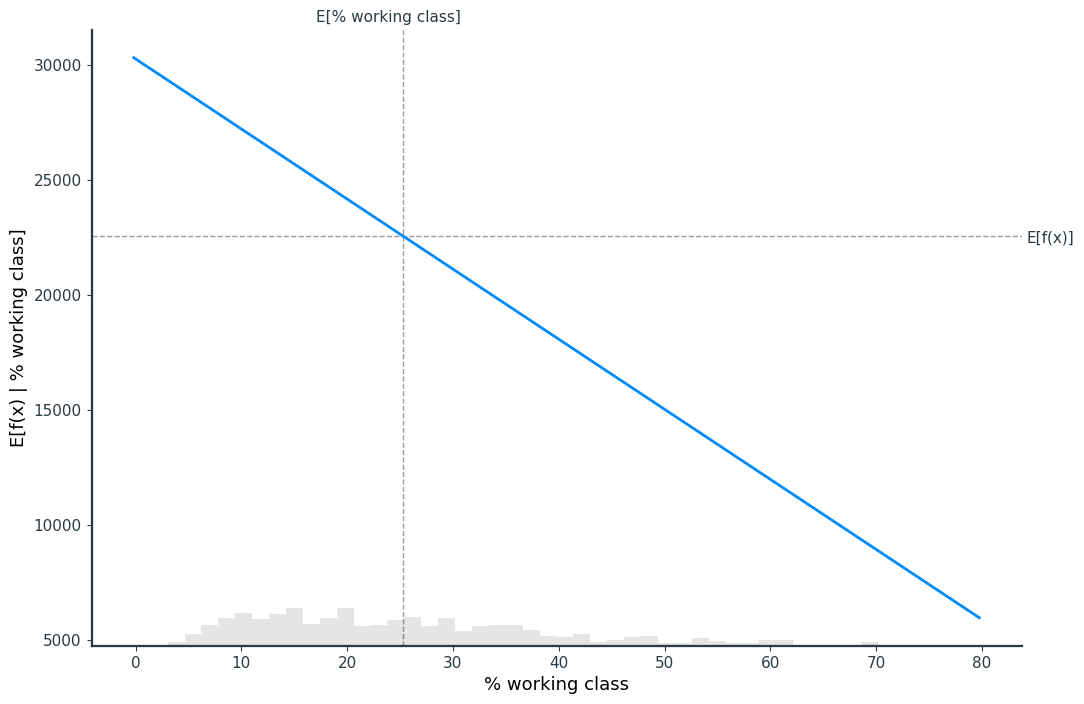

In [85]:
shap.partial_dependence_plot(
    "% working class",
    model.predict,
    df_sub_sub,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    feature_names=features,
)


## Random Forest Models

In [63]:
models = {}

# Model with no features
models["none"] = [y.mean()] * len(y)

# models with one feature
for feature in features:
    X = df[feature].values.reshape(-1, 1)
    m = RandomForestRegressor(random_state=0).fit(X, y)
    models[feature] = m.predict(X)
    
# models with two features
models_two = {}
for i, feature1 in enumerate(features):
    for feature2 in features[i+1:]:
        X = df[[feature1, feature2]].values
        m = RandomForestRegressor(random_state=0).fit(X, y)
        models[f"{feature1}, {feature2}"] = m.predict(X)
        
# model with all features
X_all = df[features]
m = RandomForestRegressor(random_state=0).fit(X_all, y)
models["all"] = m.predict(X_all)

In [64]:
print(f"Base value: ${int(models['none'][0]):,}")

Base value: $22,532


## Calculate Shapley Values

In [65]:
sv_pwc = 1/3 * (models["% working class"] - 
                models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - 
                models["number of rooms"]) +\
         1/6 * (models["% working class, Air pollution"] - 
                models["Air pollution"]) +\
         1/3 * (models["all"] - 
                models["number of rooms, Air pollution"])

sv_nor = 1/3 * (models["number of rooms"] - 
                models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - 
                models["% working class"]) +\
         1/6 * (models["number of rooms, Air pollution"] - 
                models["Air pollution"]) +\
         1/3 * (models["all"] - 
                models["% working class, Air pollution"])

sv_nc  = 1/3 * (models["Air pollution"] - 
                models["none"]) +\
         1/6 * (models["% working class, Air pollution"] - 
                models["% working class"]) +\
         1/6 * (models["number of rooms, Air pollution"] - 
                models["number of rooms"]) +\
         1/3 * (models["all"] - 
                models["% working class, number of rooms"])

## Visualise Shapley Values

### Waterfall Plot for a Single Instance

In [86]:
import plotly.graph_objects as go

i = 0
fig = go.Figure(
    go.Waterfall(
        name="waterfall",
        orientation="h",
        y=features,
        x=[sv_pwc[i], sv_nor[i], sv_nc[i]],
        base=models["none"][i],
        decreasing=dict(marker=dict(color="#fb0655")),
        increasing=dict(marker=dict(color="#008bfb"))
    )
)
fig.update_layout(
    title=f"Base: &#36;{models['none'][i]:,.0f}, Prediction: &#36;{models['all'][i]:,.0f}",
    width=700, height=350, font=dict(size=14),
)
fig.show()

### Beeswarm Plot of Shapley Values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


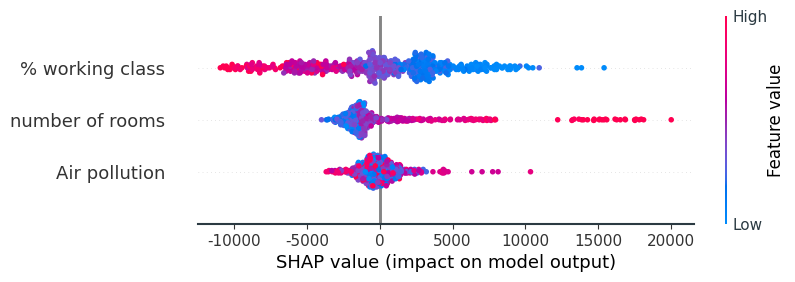

In [82]:
# shape data for beeswarm plot
df_sv = pd.DataFrame()
df_sv["feature"] = (
    ["% working class"] * len(y)
    + ["number of rooms"] * len(y)
    + ["Air pollution"] * len(y)
)
df_sv["shapley value"] = np.concatenate([sv_pwc, sv_nor, sv_nc])
df_sv["hue"] = np.concatenate(
    [
        (df["% working class"].values - df["% working class"].mean())
        / df["% working class"].std(),
        (df["number of rooms"].values - df["number of rooms"].mean())
        / df["number of rooms"].std(),
        (df["Air pollution"].values - df["Air pollution"].mean())
        / df["Air pollution"].std(),
    ]
)

# beeswarm plot
fig, ax = plt.subplots()
ax.axvline(0, c="grey", alpha=0.8)
shap.initjs()
explainer = shap.Explainer(m, X_all)
shap_values = explainer(X_all)
shap.plots.beeswarm(shap_values)